In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from ParticleFilter.Tools import resample
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns; sns.set_context('notebook')
sns.set()
%matplotlib inline

In [2]:
def scale(X):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X.min())/(X.max() - X.min()), X.min(), X.max()


def apply_scale(X, X_min, X_max):
    """

    :param X:
    :return: Normalised array like X, mean, std
    """
    return (X - X_min)/(X_max - X_min)

In [3]:
parameters = pickle.load(open("Battery_Data/Oracle/oracle_random_VPF.p", 'rb'))
t = np.array(parameters['t'], ndmin=2)
V = np.array(parameters["V"], ndmin=2)
I = np.array(parameters["I"], ndmin=2)
SoC = np.array(parameters["SoC"], ndmin=2)
Current, Current_min, Current_max = scale(I)
train_prior = False
train_vem = False
uniform_prior = "Battery_Data/Oracle/Uniform_prior.mdl"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class OracleNetwork(nn.Module):
    def __init__(self):
        super(OracleNetwork, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)
        # SMC params
        self.f_mean = torch.Tensor([0.0])
        self.f_std = torch.Tensor([0.05])
        # self.f_std = torch.Tensor([0.0002551068601502507])
        # self.g_std = 0.011334095
        self.g_std = 0.01
        self.nu = torch.Tensor([1.0 / (self.g_std * np.sqrt(2 * np.pi))])
        self.w_hist = None
        self.voltage_expected_hist = None
        self.soc_expected_hist = None

    def VoC(self, SoC):
        v_L = torch.Tensor([[parameters["v_L"]]]).to(device)
        v_0 = torch.Tensor([[parameters["v_0"]]]).to(device)
        gamma = torch.Tensor([[parameters["gamma"]]]).to(device)
        alpha = torch.Tensor([[parameters["alpha"]]]).to(device)
        beta = torch.Tensor([[parameters["beta"]]]).to(device)
        return v_L + (v_0 - v_L)*torch.exp(gamma*(SoC - 1)) + alpha*v_L*(SoC - 1) \
            + (1 - alpha)*v_L*(torch.exp(-beta) - torch.exp(-beta*torch.sqrt(SoC)))

    def forward(self, soc_init, current, voltage_measured):
        first = True
        voltage = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        soc_hist = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        self.w_hist = torch.empty((soc_init.shape[0], current.shape[1]), dtype=torch.float)
        self.voltage_expected_hist = torch.empty((1, current.shape[1]), dtype=torch.float)
        self.soc_expected_hist = torch.empty((1, current.shape[1]), dtype=torch.float)
        soc = soc_init.to(device, torch.float)
        N = soc_init.shape[0]

        I = torch.ones(N, 1) * current[0, 0]
        I = I.to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        scaled_soc = apply_scale(soc, 0.0, 1.0)
        # Estimate Z_p
        combined = torch.cat((scaled_soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)

        # Estimate prior V
        V = self.VoC(soc) - I * Z

        variational_distribution = torch.distributions.Normal(loc=self.f_mean, scale=self.f_std)

        for t in range(current.shape[1]):

            # Predict SoC
            soc = soc - I*V*parameters["E_crit_inv"]
            # Add model uncertainty
            soc = soc + torch.normal(torch.ones([N, 1]) * self.f_mean, torch.ones([N, 1]) * self.f_std).to(device)

            # Bounds
            max_test = soc[:, 0] > 1.0
            soc[max_test, 0] = 1.0
            min_test = soc[:, 0] < 0.0
            soc[min_test, 0] = 0.0000000001

            # Posterior Evidence
            I = torch.ones(N, 1) * current[0, t]
            I = I.to(device, torch.float)
            scaled_I = apply_scale(I, Current_min, Current_max)
            # Estimate Z_p
            combined = torch.cat((soc, scaled_I), 1)
            Z = torch.sigmoid(self.Z_hl1(combined))
            Z = torch.sigmoid(self.Z_hl2(Z))
            Z = self.Z_p(Z)

            # Estimate posterior V
            V = self.VoC(soc) - I*Z

            #SMC
            W = self.nu * torch.exp(-0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0))
            logW = torch.log(self.nu) - 0.5 * torch.pow((V.to("cpu") - voltage_measured[0, t]) / self.g_std, 2.0)

            max_logW = logW.max()
            loss_W = torch.exp(logW - max_logW)

            if not first:
                loss = loss + max_logW + torch.log(torch.sum(loss_W)) - torch.Tensor([np.log(N)])
            else:
                loss = max_logW + torch.log(torch.sum(loss_W)) - torch.Tensor([np.log(N)])
                first = False

            # Resampling
            soc, W = resample(soc, loss_W)

            self.w_hist[:, t] = W[:, 0]
            voltage[:, t] = V[:, 0]
            soc_hist[:, t] = soc[:, 0]
            self.voltage_expected_hist[0, t] = V.transpose(0, 1).mm(W.to(device))
            self.soc_expected_hist[0, t] = soc.transpose(0, 1).mm(W.to(device))

        return loss, voltage, soc_hist

In [5]:
saved_network = "Battery_Data/Oracle/Learnt_Oracle_gt_with_prior_v1.mdl"
saved = saved_network
vsmc = OracleNetwork()
parts = 14
N = 100

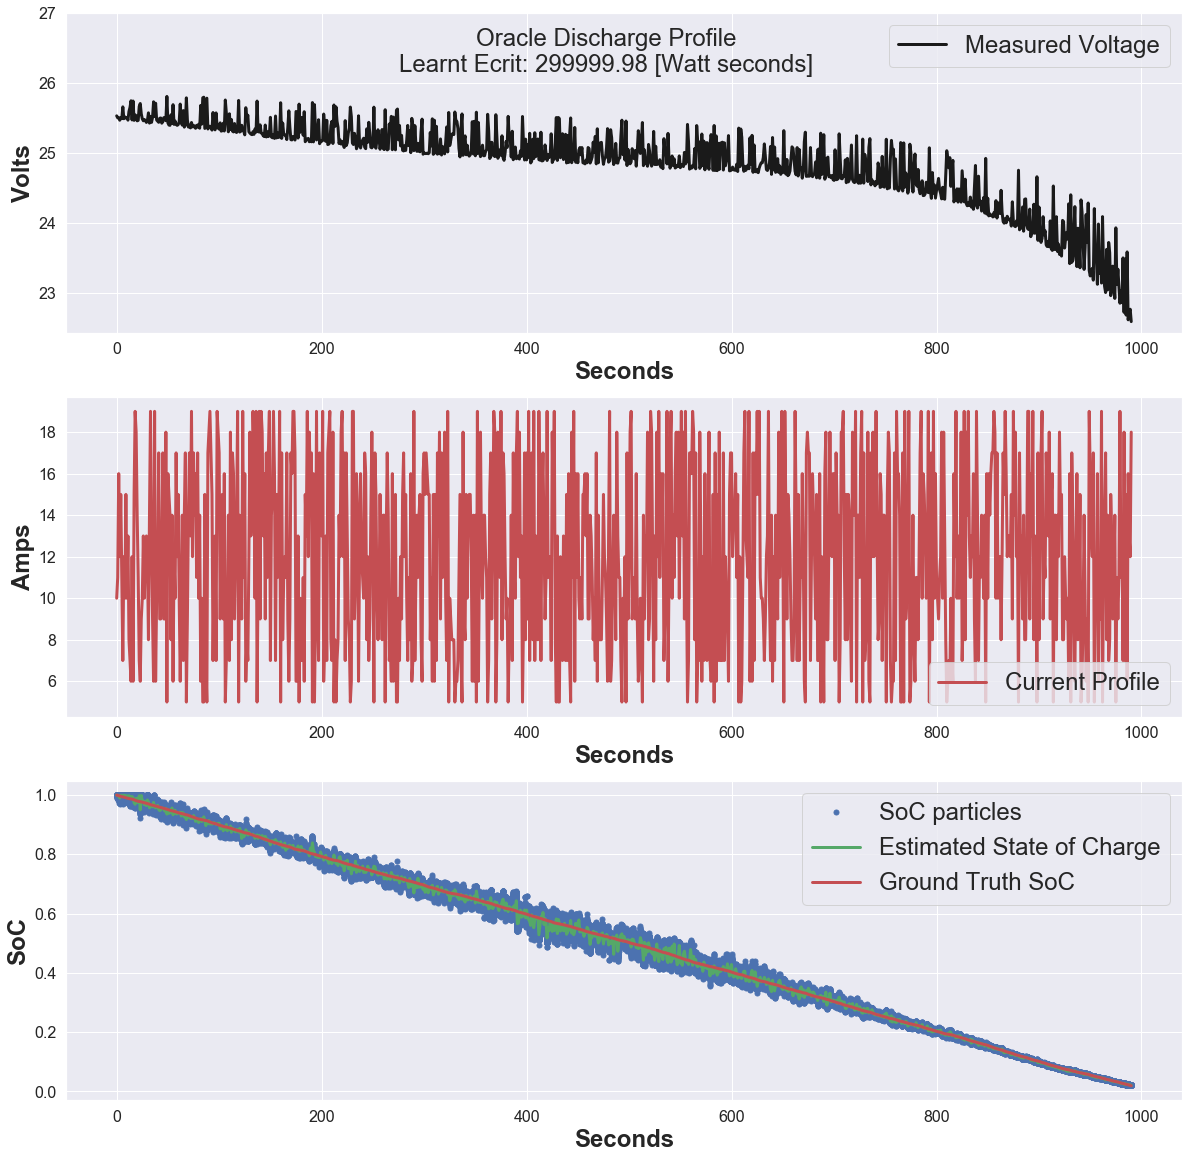

In [7]:
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
font = {"figure.titlesize": 24,
        "figure.titleweight": 'normal',
        "axes.titlesize" : 24,
        "axes.labelsize" : 24,
        "lines.linewidth" : 3,
        "lines.markersize" : 10,
        "xtick.labelsize" : 16,
        "ytick.labelsize" : 16,
        'axes.labelweight': 'bold',
        'legend.fontsize': 24.0,}
for key in font:
    matplotlib.rcParams[key] = font[key]
with torch.no_grad():
    vsmc.load_state_dict(torch.load(saved_network))
    vsmc.to(device)
    j = 0
    title = ["Oracle Discharge Profile"]
    state = torch.ones(N, 1) * 1.0
    loss, voltage, soc_hist = vsmc(state, I, V)
    seconds = torch.ones_like(vsmc.voltage_expected_hist).numpy()
    voltage_expected_hist = vsmc.voltage_expected_hist.numpy()
    soc_expected_hist = vsmc.soc_expected_hist.numpy()
    plt.figure()
    plt.suptitle(title[j] + "\nLearnt Ecrit: " + "{:.2f}".format(1.0/parameters['E_crit_inv']-0.02) \
         + " [Watt seconds]",
         y=0.87)
    plt.subplot(311)
    plt.plot(V.T, '-k', label="Measured Voltage")
    plt.xlabel("Seconds")
    plt.ylabel("Volts")
    plt.ylim(ymax=27)
    plt.legend()
    plt.subplot(312)
    plt.plot(I.T, '-r', label="Current Profile")
    plt.xlabel("Seconds")
    plt.ylabel("Amps")
    plt.legend()
    plt.subplot(313)
    plt.plot(soc_hist.numpy().T, '.b')
    plt.plot([],'.b', label="SoC particles")
    plt.plot(soc_expected_hist.T,'-g', label="Estimated State of Charge")
    plt.plot(SoC.T, '-r', label="Ground Truth SoC")
    plt.xlabel("Seconds")
    plt.ylabel("SoC")
    plt.legend()
    plt.show()

In [8]:
class Polarising_Impedance_Map(nn.Module):
    def __init__(self):
        super(Polarising_Impedance_Map, self).__init__()
        self.Z_hl1 = nn.Linear(2, 1024)
        self.Z_hl2 = nn.Linear(1024, 512)
        self.Z_p = nn.Linear(512, 1)

    def forward(self, soc_prior, current_prior):

        if soc_prior.shape[1] == 1:
            soc = torch.from_numpy(soc_prior).to(device, torch.float)
        else:
            soc = torch.from_numpy(soc_prior.T).to(device, torch.float)
        # A prior estimate
        if current_prior.shape[1] == 1:
            I = torch.from_numpy(current_prior).to(device, torch.float)
        else:
            I = torch.from_numpy(current_prior.T).to(device, torch.float)
        scaled_I = apply_scale(I, Current_min, Current_max)
        # Estimate Z_p
        combined = torch.cat((soc, scaled_I), 1)
        Z = torch.sigmoid(self.Z_hl1(combined))
        Z = torch.sigmoid(self.Z_hl2(Z))
        Z = self.Z_p(Z)
        return Z

In [9]:
Z_pol = Polarising_Impedance_Map()
Z_pol.load_state_dict(torch.load(saved))
Z_pol.to(device)
soc_map = np.array(np.linspace(0, 1.0, 1000), ndmin=2)

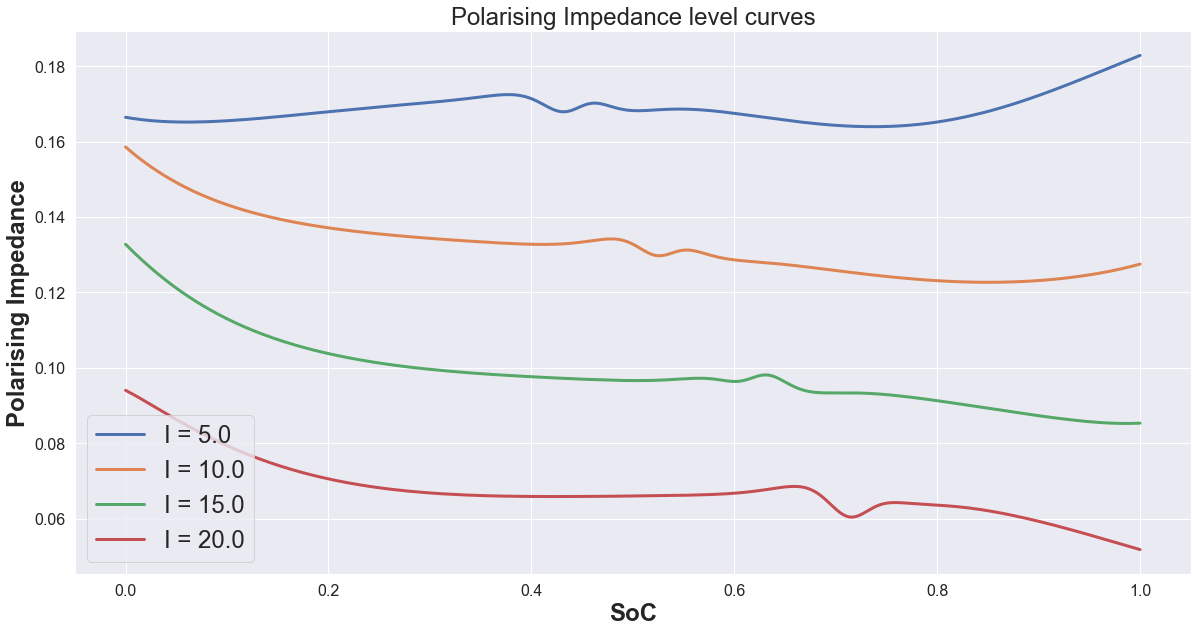

In [10]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
# font = {"figure.titlesize": 20,
#         "figure.titleweight": 'normal',
#         "axes.titlesize" : 20,
#         "axes.labelsize" : 20,
#         "lines.linewidth" : 3,
#         "lines.markersize" : 10,
#         "xtick.labelsize" : 16,
#         "ytick.labelsize" : 16,
#         'axes.labelweight': 'bold',
#         'legend.fontsize': 20.0,}

Z_map = []
plt.figure()
current_scale = [5.0, 10.0, 15.0, 20.0]
for i in current_scale:
    with torch.no_grad():
        Z = Z_pol(soc_map.T, np.ones((1000, 1))*i)
        Z_map.append(Z.cpu().numpy())
        plt.plot(soc_map.T, Z.cpu().numpy(), label="I = {}".format(i))
plt.title("Polarising Impedance level curves")
plt.xlabel("SoC")
plt.ylabel("Polarising Impedance")
plt.legend()
plt.show()

# Z_map = []
# plt.figure()
# current_scale = np.arange(0.5, 7.0, 1.0)
# for i in range(current_scale.shape[0]):
#     with torch.no_grad():
#         Z = Z_pol(soc_map.T, np.ones((1000, 1))*current_scale[i])
#         Z_map.append(Z.cpu().numpy())
#         plt.plot(soc_map.T, Z.cpu().numpy(), label="I = {}".format(current_scale[i]))
# plt.title("Polarising Impedance level curves [zoomed]")
# plt.xlabel("SoC")
# plt.ylabel("Polarising Impedance")
# plt.ylim((0.0725, 0.0875))
# plt.legend()
# plt.show()

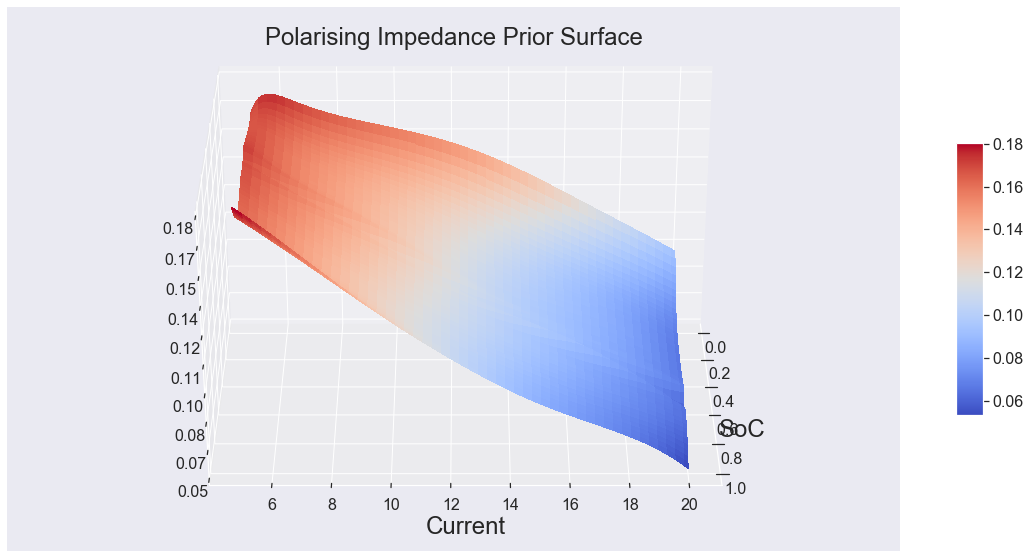

In [11]:
matplotlib.rcParams["axes.labelsize"] = 24
matplotlib.rcParams["axes.labelweight"] = 'normal'
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title("Polarising Impedance Prior Surface")
# Make data.
X = soc_map
Y = np.linspace(5.0, 20.0, 100)
Z_surf = []
for i in range(Y.shape[0]):
    with torch.no_grad():
        Z = Z_pol(soc_map.T, np.ones((1000, 1))*Y[i])
        Z_surf.append(Z.cpu().numpy())
X, Y = np.meshgrid(X, Y)
Z = np.concatenate(Z_surf, axis=1).T

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(30, 0)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.xlabel("\nSoC")
plt.ylabel("\nCurrent")
# ax.set_zlabel('Polarising Impedance')

plt.show()

In [12]:
import sys
sys.path.append("/home/chris/Dropbox/University/PhD/SoLE/MonteCarloToolbox")
from OptimisedTools import kernel, VoC

In [13]:
def get_saved_kernel_parameters():
    kls_parameters = pickle.load(open("/home/chris/Dropbox/University/PhD/SoLE/MonteCarloToolbox/Rpol_kernel_parameters.p", 'rb'))
    alpha_Rpol = [kls_parameters["Discharge"]["alpha_Rpol"], kls_parameters["Charge"]["alpha_Rpol"]]
    support_vectors = [kls_parameters["Discharge"]["support_vectors"], kls_parameters["Charge"]["support_vectors"]]
    kernel_width = [kls_parameters["Discharge"]["kernel_width"], kls_parameters["Charge"]["kernel_width"]]
    return alpha_Rpol, support_vectors, kernel_width

In [14]:
base_alpha_Rpol, base_support_vectors, base_kernel_width = get_saved_kernel_parameters()

In [15]:
Z_level_curves = []
kernel_width = base_kernel_width[0]
alpha_Rpol = np.concatenate((base_alpha_Rpol[1], base_alpha_Rpol[0]), axis=1)
support_vectors = np.concatenate((base_support_vectors[1], base_support_vectors[0]), axis=1)

def really_inefficient_kernel(I, SoC):
    R = np.zeros((1, 1), dtype=np.double)
    input_matrix = np.matrix([I, SoC]).T
    kernel(R,
           input_matrix,
           support_vectors,
           kernel_width,
           alpha_Rpol)
    return R
    
for i in range(soc_map.shape[1]):
    I_curves = [5.0, 10.0, 12.5, 15.0]
    level_curve = []
    for I in I_curves:
        level_curve.append(really_inefficient_kernel(I, soc_map[0, i])[0, 0])
    Z_level_curves.append(level_curve)
Z_level_curves = np.array(Z_level_curves)

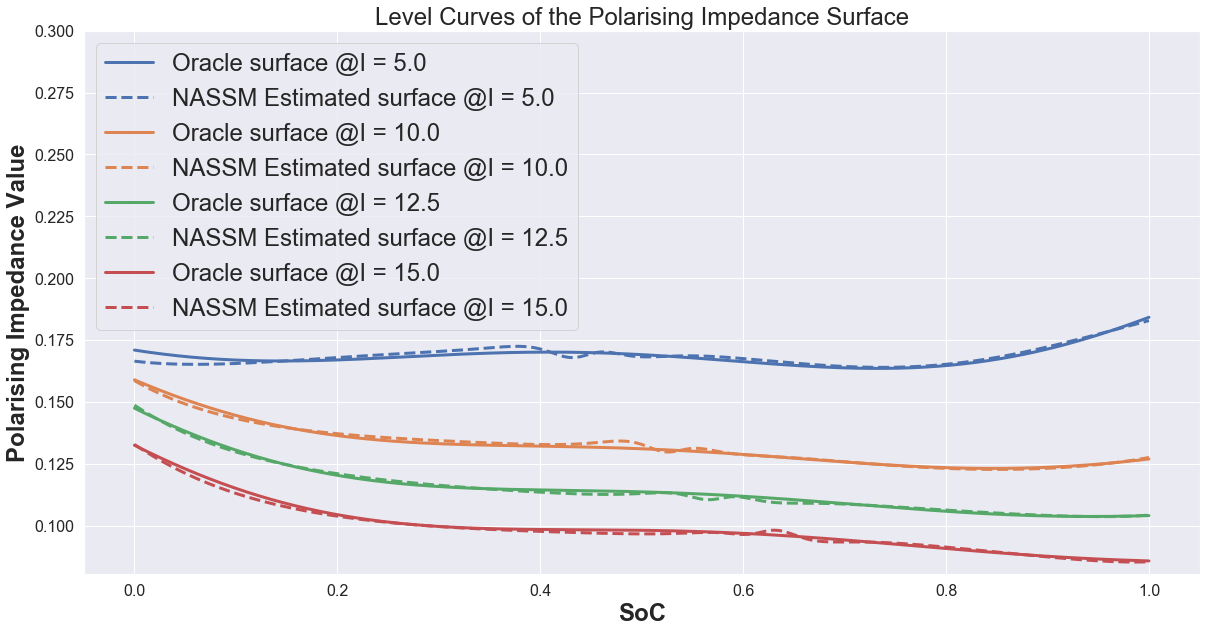

In [16]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
# font = {"figure.titlesize": 20,
#         "figure.titleweight": 'normal',
#         "axes.titlesize" : 20,
#         "axes.labelsize" : 20,
#         "lines.linewidth" : 3,
#         "lines.markersize" : 10,
#         "xtick.labelsize" : 16,
#         "ytick.labelsize" : 16,
#         'axes.labelweight': 'bold',
#         'legend.fontsize': 20.0,}
for key in font:
    matplotlib.rcParams[key] = font[key]
plt.figure()
I_curves = [5.0, 10.0, 12.5, 15.0]
level_curve = []
for index, I in enumerate(I_curves):
    with torch.no_grad():
        Z = Z_pol(soc_map.T, np.ones((1000, 1))*I)
    plt.plot(soc_map.T, Z_level_curves[:, index], label="Oracle surface @I = {}".format(I), color='C{}'.format(index))
    plt.plot(soc_map.T, Z.cpu().numpy(), '--', label="NASSM Estimated surface @I = {}".format(I), color='C{}'.format(index))
plt.title("Level Curves of the Polarising Impedance Surface", )
plt.xlabel("SoC")
plt.ylabel("Polarising Impedance Value")
plt.legend()
plt.ylim(ymax=0.3)
plt.show()
        

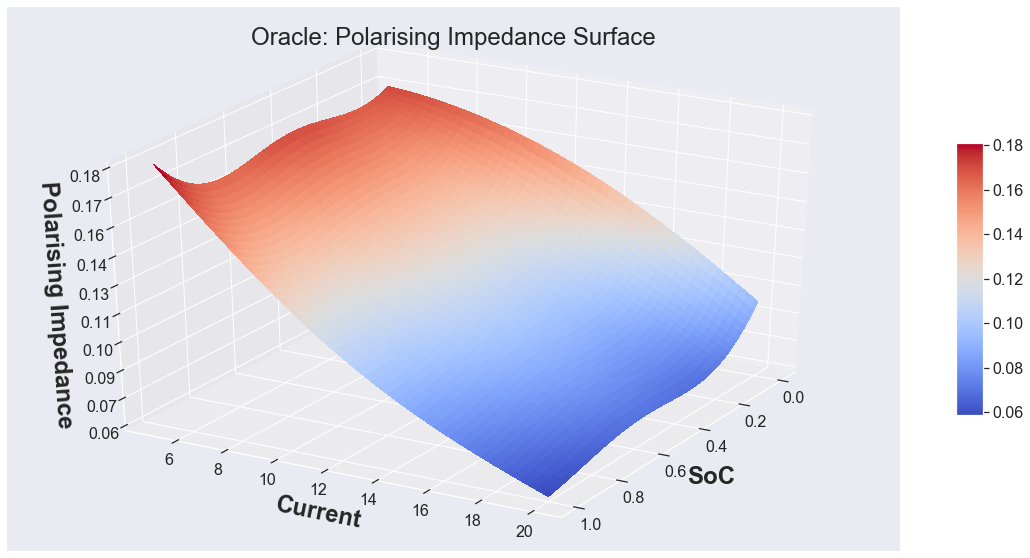

In [17]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
# font = {"figure.titlesize": 20,
#         "figure.titleweight": 'normal',
#         "axes.titlesize" : 20,
#         "axes.labelsize" : 20,
#         "lines.linewidth" : 3,
#         "lines.markersize" : 10,
#         "xtick.labelsize" : 16,
#         "ytick.labelsize" : 16,
#         'axes.labelweight': 'bold',
#         'legend.fontsize': 20.0,}
for key in font:
    matplotlib.rcParams[key] = font[key]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_title("Oracle: Polarising Impedance Surface")
# Make data.
X = soc_map
Y = np.linspace(5.0, 20.0, 100)
Z_surf = []
for i in range(Y.shape[0]):
    Z = []
    for j in range(soc_map.shape[1]):
        Z.append(really_inefficient_kernel(Y[i], soc_map[0, j])[0, 0])
    Z_surf.append(Z)
X, Y = np.meshgrid(X, Y)
Z = np.array(Z_surf)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(30, 30)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.xlabel("\nSoC")
plt.ylabel("\nCurrent")
ax.set_zlabel('\nPolarising Impedance')

plt.show()